<a href="https://colab.research.google.com/github/johnnysDeu/Thesis/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=jztwpsIzEGc

Building a CNN from scratch with any image dataset

!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [1]:
#!pip install "tensorflow<2.11"

In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
#!pip install --upgrade pip

In [4]:
#!pip install torchvision

In [5]:

#!pip list
import torch

In [6]:
#!nvidia-smi

In [7]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [8]:
# add headings with ##(space) on the markdowns

In [9]:
#!pip install tensorflor keras

In [10]:
import tensorflow as tf
import os

In [11]:
!nvidia-smi

Thu Apr 11 20:49:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  | 00000000:2D:00.0  On |                  N/A |
|  0%   50C    P8              17W / 125W |    675MiB /  6144MiB |     21%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [14]:
#! nvidia-smi

In [15]:
#!pip install opencv-python

## Imports

In [16]:
import tensorflow as tf
import os
import cv2
import imghdr

## Removing false images

In [17]:
#from google.colab import drive # fur colab
#drive.mount('/content/drive')

In [18]:
import numpy as np
from matplotlib import pyplot as plt

In [19]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [20]:
#path = '/content/drive/MyDrive/Colab Notebooks/Thesis'
#os.chdir(path)

In [21]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [22]:
data_dir='data'
os.listdir(data_dir)

['Ads', 'Sample_Images']

In [23]:
os.listdir(os.path.join(data_dir,'Ads'))

['converted_iframe_1005_AD.jpg',
 'converted_iframe_1006_AD.jpg',
 'converted_iframe_100_AD.jpg',
 'converted_iframe_101_AD.jpg',
 'converted_iframe_1025_AD.jpg',
 'converted_iframe_102_AD.jpg',
 'converted_iframe_103_AD.jpg',
 'converted_iframe_1046_AD.jpg',
 'converted_iframe_104_AD.jpg',
 'converted_iframe_1058_AD.jpg',
 'converted_iframe_105_AD.jpg',
 'converted_iframe_1062_AD.jpg',
 'converted_iframe_106_AD.jpg',
 'converted_iframe_1075_AD.jpg',
 'converted_iframe_1079_AD.jpg',
 'converted_iframe_107_AD.jpg',
 'converted_iframe_1087_AD.jpg',
 'converted_iframe_108_AD.jpg',
 'converted_iframe_1094_AD.jpg',
 'converted_iframe_1095_AD.jpg',
 'converted_iframe_109_AD.jpg',
 'converted_iframe_10_AD.jpg',
 'converted_iframe_1100_AD.jpg',
 'converted_iframe_110_AD.jpg',
 'converted_iframe_1116_AD.jpg',
 'converted_iframe_111_AD.jpg',
 'converted_iframe_1122_AD.jpg',
 'converted_iframe_1138_AD.jpg',
 'converted_iframe_1139_AD.jpg',
 'converted_iframe_1141_AD.jpg',
 'converted_iframe_1145_

In [27]:
imgTest= cv2.imread(os.path.join('data','Sample_Images','converted_main_3.jpg'))
#imgTest= cv2.imread(os.path.join('data','Sample_Images','main_2.jpg'))

In [28]:
type(imgTest)

numpy.ndarray

In [29]:
imgTest.shape

(602, 1200, 3)

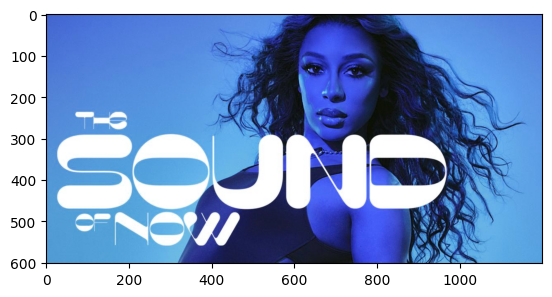

In [30]:
plt.imshow(imgTest)

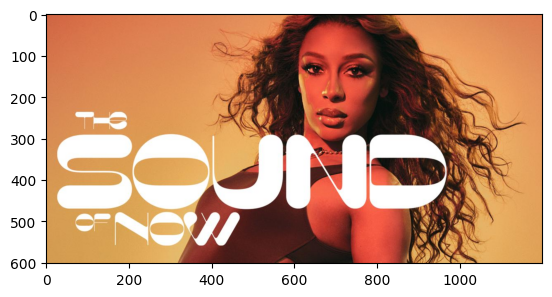

In [31]:
plt.imshow(cv2.cvtColor(imgTest, cv2.COLOR_BGR2RGB))
plt.show()

Load Data

In [32]:
#tf.data.Dataset??

In [33]:
#tf.keras.utils.audio_dataset_from_directory??

In [34]:
data=tf.keras.utils.image_dataset_from_directory('data', batch_size=32)

Found 11262 files belonging to 2 classes.


In [35]:
data_iterator=data.as_numpy_iterator()


In [36]:
batch=data_iterator.next()


In [37]:
len(batch) # batch contain 2 items, the image batch[0] and the label batch[1]

2

In [38]:
batch[0].shape # images are numpy arrays

(32, 256, 256, 3)

In [39]:
batch[1] # labels

array([0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

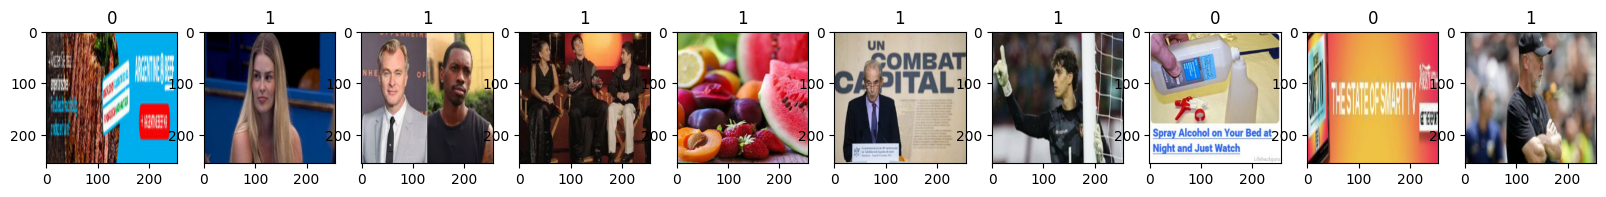

In [40]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20)) # class 1= simple image, class 0 = Ad
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

From the above plot, we see how the function assigns the classes (this may change from run-to-run):

simple image = 1 <br>
Ad = 0

## Preprocess data

In [41]:
#print(batch[0].max()) # our pixels are between values 0 and 255. we will scale them to be between 0 and 1

In [42]:
#batch[0] / 255

In [43]:
scaled= data.map(lambda x,y: (x/255, y)) # as we load a batch from the pipeline, we scale them on the go

In [44]:
scaled.as_numpy_iterator().next()

(array([[[[0.5372549 , 0.5411765 , 0.52156866],
          [0.5356005 , 0.53952205, 0.5199142 ],
          [0.530576  , 0.53449756, 0.5148897 ],
          ...,
          [0.5294118 , 0.5294118 , 0.52156866],
          [0.5316789 , 0.5316789 , 0.5238358 ],
          [0.53333336, 0.53333336, 0.5254902 ]],
 
         [[0.5372549 , 0.5411765 , 0.52156866],
          [0.5356005 , 0.53952205, 0.5199142 ],
          [0.530576  , 0.53449756, 0.5148897 ],
          ...,
          [0.5317019 , 0.5317019 , 0.5238588 ],
          [0.53396904, 0.53396904, 0.5261259 ],
          [0.5356235 , 0.5356235 , 0.52778035]],
 
         [[0.5396599 , 0.5435815 , 0.52397364],
          [0.53800553, 0.5419271 , 0.52231926],
          [0.532981  , 0.53690255, 0.5172947 ],
          ...,
          [0.53489286, 0.53489286, 0.5270497 ],
          [0.53800553, 0.53800553, 0.5301624 ],
          [0.5396599 , 0.5396599 , 0.5318168 ]],
 
         ...,
 
         [[0.26721814, 0.26721814, 0.22800244],
          [0.27058

In [45]:
scaled_iterator=scaled.as_numpy_iterator()

In [46]:
batch = scaled_iterator.next()

In [47]:
batch[0].min()

0.0

In [48]:
scaled.as_numpy_iterator().next()

(array([[[[0.9529412 , 1.        , 0.99215686],
          [0.9529412 , 1.        , 0.99215686],
          [0.9529412 , 1.        , 0.99215686],
          ...,
          [0.8749081 , 0.9490196 , 0.9864737 ],
          [0.87058824, 0.9490196 , 0.9843137 ],
          [0.87058824, 0.9490196 , 0.9843137 ]],
 
         [[0.9529412 , 1.        , 0.99215686],
          [0.9529412 , 1.        , 0.99215686],
          [0.9529412 , 1.        , 0.99215686],
          ...,
          [0.8759959 , 0.9501074 , 0.98756146],
          [0.87208945, 0.9505208 , 0.9858149 ],
          [0.87208945, 0.9505208 , 0.9858149 ]],
 
         [[0.9529412 , 1.        , 0.99215686],
          [0.9529412 , 1.        , 0.99215686],
          [0.9529412 , 1.        , 0.99215686],
          ...,
          [0.8786155 , 0.952727  , 0.9901811 ],
          [0.87570465, 0.954136  , 0.9894301 ],
          [0.87570465, 0.954136  , 0.9894301 ]],
 
         ...,
 
         [[0.27057293, 0.17815563, 0.1193321 ],
          [0.29922

# Split Data

In [49]:
#len(scaled)
len(data)

352

In [50]:
train_size = int(len(scaled)*.7)# batch size 8, 156 batches, 32, 41 batches
val_size = int(len(scaled)*.2) # 44 batces
test_size = int(len(scaled)*.1) # 22 batches
#test_size = int(len(scaledtest)) # 22 batches

In [51]:
print(f'Train Size: {train_size}, Val Size:{val_size}, Test Size: {test_size}')


Train Size: 246, Val Size:70, Test Size: 35


In [52]:
train = scaled.take(train_size)
val = scaled.skip(train_size).take(val_size)
test = scaled.skip(train_size+val_size).take(test_size)

In [53]:
train.as_numpy_iterator().next()[0]

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [54]:
batch[0]

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.01176471, 0.20392157, 0.33333334],
         [0.01176471, 0.20392157, 0.33333334],
         [0.01176471, 0.20392157, 0.33333334]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.01176471, 0.20392157, 0.33333334],
         [0.01176471, 0.20392157, 0.33333334],
         [0.01176471, 0.20392157, 0.33333334]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.01176471, 0.20392157, 0.33333334],
         [0.01176471, 0.20392157, 0.33333334],
         [0.01176471, 0.20392157, 0.33333334]],

        ...,

        [[0.        , 0.00748315, 0.01888787],
         [0.        , 0.00753096, 0.01794182]

In [55]:
len(train)

246

# Model

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten ,Dropout

In [57]:
model = Sequential()

In [58]:
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3))) # mhpws 150,150
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [59]:
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

# Train

In [61]:
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20


246/246 [==============================] - 27s 91ms/step - loss: 0.2945 - accuracy: 0.8991 - val_loss: 0.3155 - val_accuracy: 0.8634
Epoch 2/20
246/246 [==============================] - 23s 92ms/step - loss: 0.2142 - accuracy: 0.9148 - val_loss: 0.2944 - val_accuracy: 0.9205
Epoch 3/20
246/246 [==============================] - 22s 88ms/step - loss: 0.1828 - accuracy: 0.9313 - val_loss: 0.1847 - val_accuracy: 0.9304
Epoch 4/20
246/246 [==============================] - 22s 88ms/step - loss: 0.1628 - accuracy: 0.9408 - val_loss: 0.1810 - val_accuracy: 0.9402
Epoch 5/20
246/246 [==============================] - 22s 88ms/step - loss: 0.1491 - accuracy: 0.9493 - val_loss: 0.1619 - val_accuracy: 0.9429
Epoch 6/20
246/246 [==============================] - 22s 88ms/step - loss: 0.1344 - accuracy: 0.9538 - val_loss: 0.2253 - val_accuracy: 0.9335
Epoch 7/20
246/246 [==============================] - 23s 92ms/step - loss: 0.1220 - accuracy: 0.9581 - val_loss: 0.2266 - val_accuracy: 0.9424
Epo

In [ ]:
model.save('Ad_classifier_medium_1.h5')

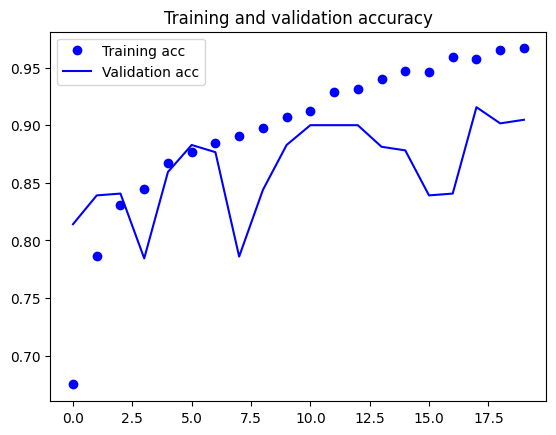

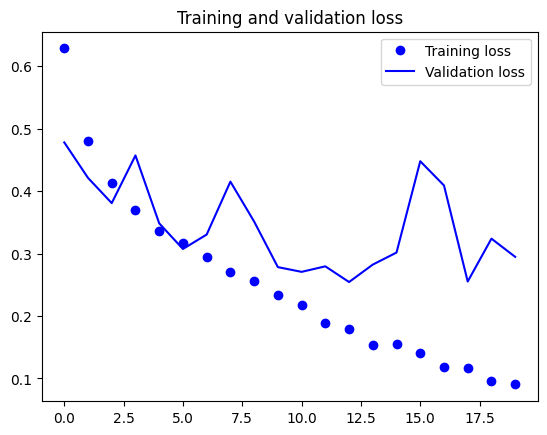

In [ ]:
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluate

In [ ]:

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    print(f'Precision: {pre.result()}, Recall:{re.result()}, Accuracy: {acc.result()}')

1/1 [==============================] - 0s 77ms/step
Precision: 0.8695651888847351, Recall:0.8695651888847351, Accuracy: 0.8125
1/1 [==============================] - 0s 29ms/step
Precision: 0.7727272510528564, Recall:0.8947368264198303, Accuracy: 0.78125
1/1 [==============================] - 0s 29ms/step
Precision: 0.8253968358039856, Recall:0.8965517282485962, Accuracy: 0.8229166865348816
1/1 [==============================] - 0s 29ms/step
Precision: 0.8505747318267822, Recall:0.9135802388191223, Accuracy: 0.84375
1/1 [==============================] - 0s 29ms/step
Precision: 0.8648648858070374, Recall:0.9230769276618958, Accuracy: 0.856249988079071
1/1 [==============================] - 0s 30ms/step
Precision: 0.8740741014480591, Recall:0.9365079402923584, Accuracy: 0.8697916865348816
1/1 [==============================] - 0s 28ms/step
Precision: 0.875, Recall:0.9300699234008789, Accuracy: 0.8705357313156128
1/1 [==============================] - 0s 29ms/step
Precision: 0.8863636255

# Extra Testing on Unseen Data

In [ ]:
import cv2

In [ ]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [ ]:
#img = cv2.imread('sim.jpg')
#img= cv2.imread(os.path.join('testData','4.png')) # s (246).jpg, 9.png, 4.png, s (481).jpg
img= cv2.imread(os.path.join('unseen data','iframe_7.jpg')) # futurama.jpeg, homer-simpson-wallpaper-preview.jpg , zoid.jpeg, bart-simpson-.jpg, fry.jpeg, homer-simpson-the-simpsons-.jpg, marg.jpg
#img

In [ ]:
len(img)


1000

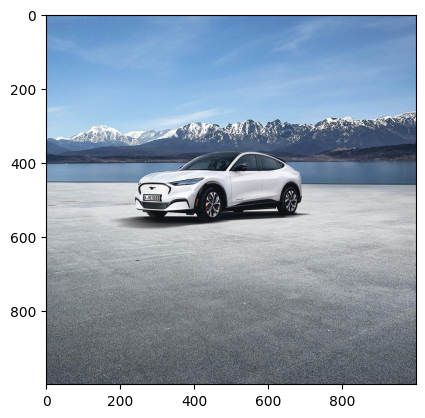

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
#plt.imshow(resize.numpy().astype(int))
#plt.show()

In [ ]:
resize.shape

TensorShape([256, 256, 3])

In [ ]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 74ms/step


array([[0.02548153]], dtype=float32)

In [ ]:
#class 1= futurama, class 0 = simpsons

if yhat < 0.5:
    print(f'Predicted Simple Image')
else:
    print(f'Predicted Ad')

Predicted Simple Image


# Saving the model

In [ ]:
from keras.models import load_model

In [ ]:
#model.save(os.path.join('models','futurama_and_simpsons_First.h5'))
#model.summary()